In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# plotting examples

In [3]:
df = pd.read_csv('../input/hourly-energy-consumption/DOM_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

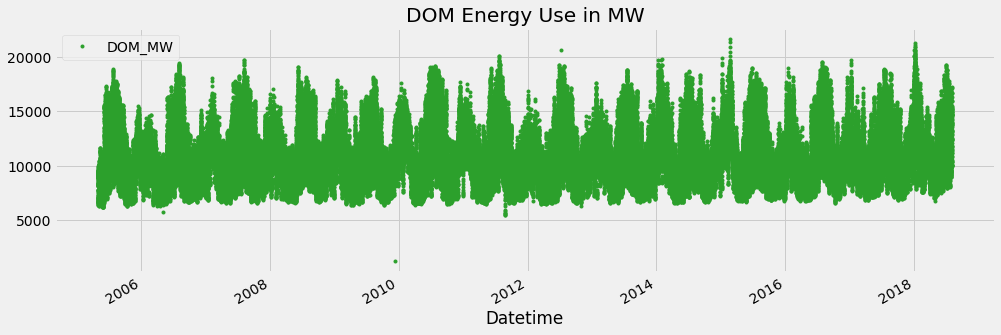

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[2],
        title='DOM Energy Use in MW')
plt.show()

# Splitting Train/Test and cross validation set

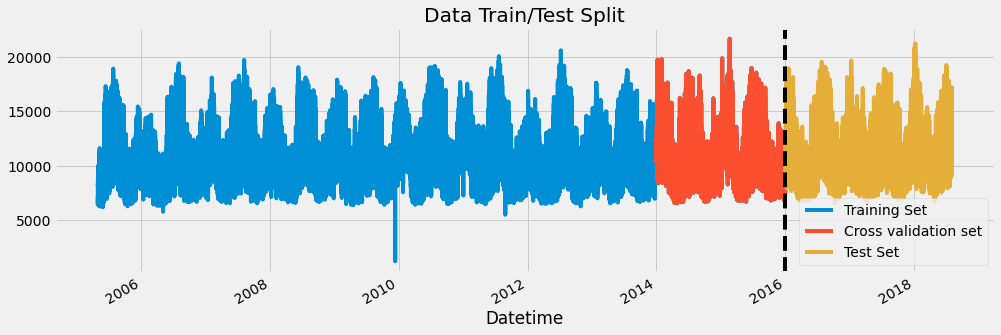

In [5]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']
cross_val = train.loc[train.index > '01-01-2014']
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
cross_val.plot(ax=ax, label='Cross validation set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set','Cross validation set', 'Test Set'])
plt.show()

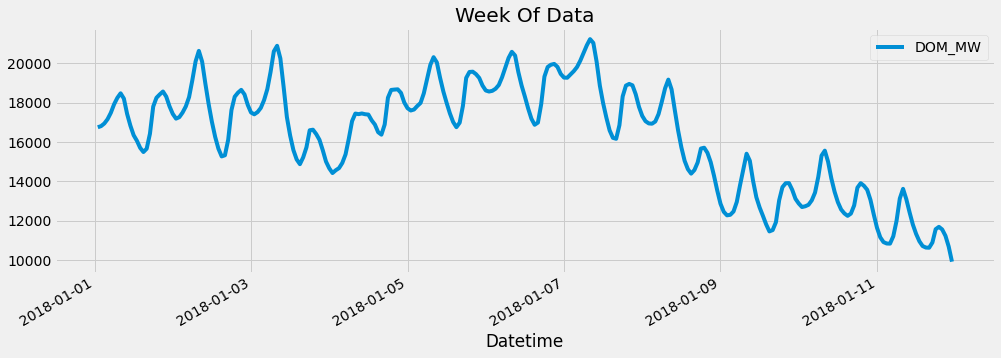

In [6]:
df.loc[(df.index > '01-01-2018') & (df.index < '01-12-2018')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation¶

In [7]:
df.DOM_MW.head

<bound method NDFrame.head of Datetime
2005-12-31 01:00:00     9389.0
2005-12-31 02:00:00     9070.0
2005-12-31 03:00:00     9001.0
2005-12-31 04:00:00     9042.0
2005-12-31 05:00:00     9132.0
                        ...   
2018-01-01 20:00:00    18418.0
2018-01-01 21:00:00    18567.0
2018-01-01 22:00:00    18307.0
2018-01-01 23:00:00    17814.0
2018-01-02 00:00:00    17428.0
Name: DOM_MW, Length: 116189, dtype: float64>

In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

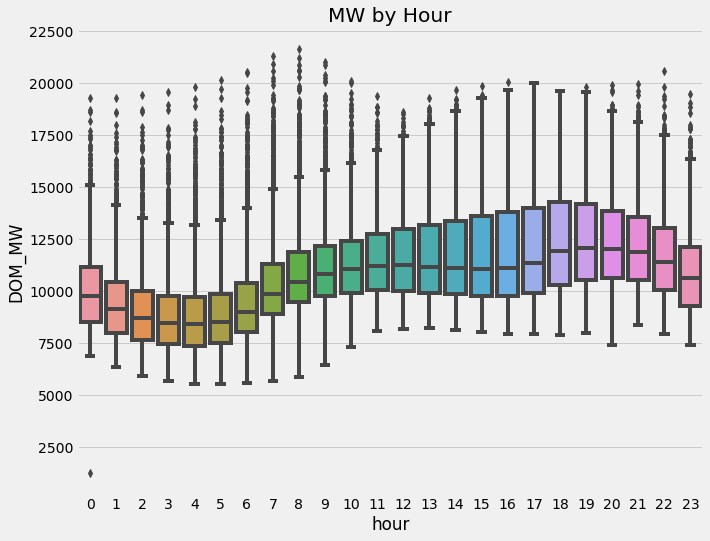

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='DOM_MW')
ax.set_title('MW by Hour')
plt.show()

# XGBoost regression

create features for dataset

In [10]:
train = create_features(train)
cross = create_features(cross_val)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'DOM_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_cross = cross[FEATURES]
y_cross = cross[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=100,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_cross, y_cross)],
        verbose=100)

[11:50:18] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11029.65009	validation_1-rmse:11280.19222
[100]	validation_0-rmse:4321.11184	validation_1-rmse:4554.47824
[200]	validation_0-rmse:2113.11027	validation_1-rmse:2319.51209
[300]	validation_0-rmse:1535.15560	validation_1-rmse:1708.68095
[400]	validation_0-rmse:1400.18545	validation_1-rmse:1542.06056
[500]	validation_0-rmse:1354.75192	validation_1-rmse:1488.00546
[600]	validation_0-rmse:1328.52561	validation_1-rmse:1456.80073
[700]	validation_0-rmse:1310.82853	validation_1-rmse:1435.46373
[800]	validation_0-rmse:1295.67377	validation_1-rmse:1422.41503
[900]	validation_0-rmse:1282.78240	validation_1-rmse:1408.30045
[999]	validation_0-rmse:1269.86310	validation_1-rmse:1394.46560


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

# Result on Test Set

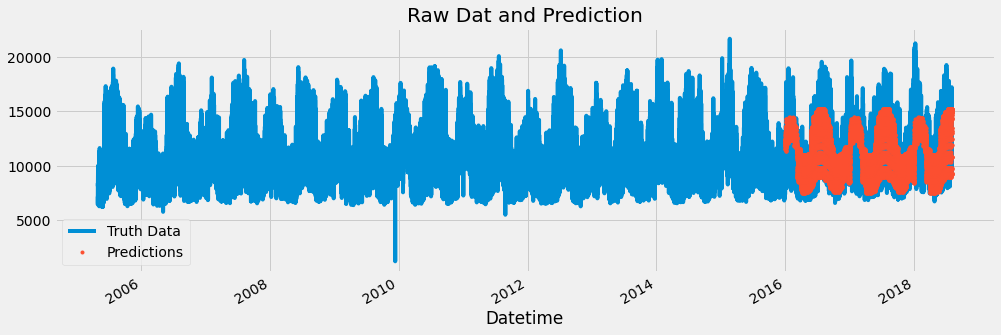

In [12]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['DOM_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

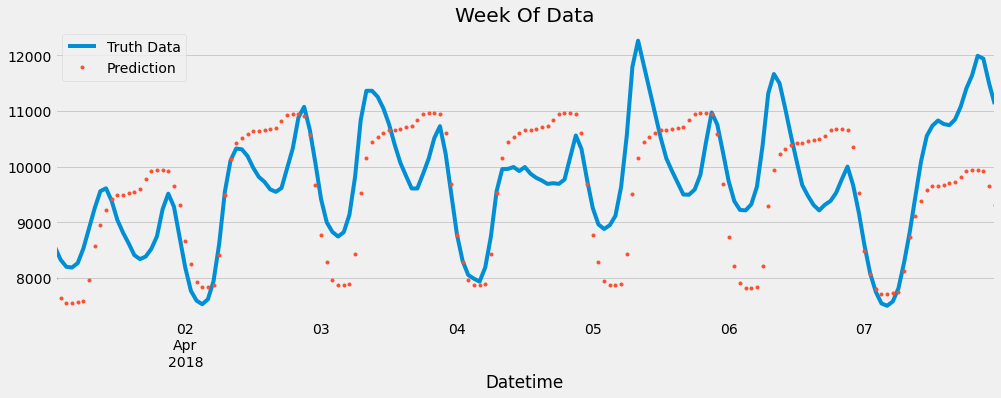

In [13]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['DOM_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# RMSE Score

In [14]:
score = np.sqrt(mean_squared_error(test['DOM_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1751.39
